In [1]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import torch
import matplotlib.pyplot as plt
# from tqdm import tqdm_notebook
%matplotlib inline 
# from google.colab.patches import cv2_imshow
from IPython.display import HTML #imports to play videos
from base64 import b64encode 
import cv2 as cv
from skimage.metrics import structural_similarity
import glob
import time
from PIL import Image
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face
from tqdm import tqdm

import math
import pickle
from functools import partial
from collections import defaultdict

from PIL import Image
from glob import glob

import cv2
import skimage.measure
import albumentations as A
from tqdm.notebook import tqdm 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models.video import mc3_18, r2plus1d_18

from facenet_pytorch import MTCNN

In [2]:
df = pd.read_csv("full_dataset.csv")

In [3]:
df.head()

,path,label,resolution,frame_count,fps,set
0,Celeb-synthesis\id6_id2_0003.mp4,0,944x500,372.0,30.0,train
1,Celeb-synthesis\id49_id53_0006.mp4,0,856x478,330.0,30.0,train
2,YouTube-real\00105.mp4,1,892x500,504.0,30.0,train
3,Celeb-synthesis\id16_id30_0002.mp4,0,950x500,363.0,30.0,train
4,Celeb-synthesis\id6_id16_0003.mp4,0,944x500,372.0,30.0,train


In [4]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [5]:
missing_data(df)

,path,label,resolution,frame_count,fps,set
Total,0,0,518,518,518,0
Percent,0.0,0.0,7.350646,7.350646,7.350646,0.0
Types,object,int64,object,float64,float64,object


In [6]:
def unique_values(data):
    total = data.count()
    tt = pd.DataFrame(total)
    tt.columns = ['Totals']
    uniques = []
    for col in data.columns:
        unique = data[col].nunique() #collect all unique instances
        uniques.append(unique)
    tt['Uniques'] = uniques
    return(np.transpose(tt))

In [7]:
unique_values(df)

,path,label,resolution,frame_count,fps,set
Totals,7047,7047,6529,6529,6529,7047
Uniques,7047,2,141,293,26,3


In [8]:
def most_frequent_values(data):
    total = data.count()
    tt = pd.DataFrame(total)
    tt.columns = ['Total']
    items = []
    vals = []
    for col in data.columns:
        itm = data[col].value_counts().index[0]
        val = data[col].value_counts().values[0]
        items.append(itm)
        vals.append(val)
    tt['Most frequent item'] = items
    tt['Frequence'] = vals
    tt['Percent from total'] = np.round(vals / total * 100, 3)
    return(np.transpose(tt))

In [9]:
most_frequent_values(df)

,path,label,resolution,frame_count,fps,set
Total,7047,7047,6529,6529,6529,7047
Most frequent item,Celeb-synthesis\id6_id2_0003.mp4,0,856x478,319.0,30.0,train
Frequence,1,5979,1251,125,6357,5223
Percent from total,0.014,84.845,19.161,1.915,97.366,74.117


In [10]:
import matplotlib.pyplot as plt

def plot_count(feature, title, df, size=2, categories = 10):
    '''
    Plot count of classes / feature using only matplotlib
    param feature: the feature to analyze
    param title: title to add to the graph
    param df: dataframe from which we plot feature's classes distribution 
    param size: default 1.
    '''
    if df.empty or feature not in df.columns or df[feature].dropna().empty:
        print("DataFrame is empty or feature does not exist.")
        return

    total = float(len(df))
    if total == 0:
        print("DataFrame has no data.")
        return

    # Count occurrences of each category
    value_counts = df[feature].value_counts().nlargest(categories)  # Focus on the top 20 categories, similar to the Seaborn version

    f, ax = plt.subplots(1, 1, figsize=(4*size, 4*size))
    bars = ax.bar(value_counts.index, value_counts.values, color='salmon')  # Use bar plot from matplotlib

    ax.set_title("Number and percentage of {}".format(title))
    ax.set_xlabel(feature)
    ax.set_ylabel('Counts')

    if len(value_counts) > 5:
        plt.xticks(rotation=45)

    # Annotate the bars with percentages
    for bar in bars:
        height = bar.get_height()
        percentage = 100 * height / total
        ax.text(bar.get_x() + bar.get_width() / 2, height + 3, f'{percentage:.2f}%', ha='center', va='bottom')

    plt.show()

# Example usage assuming df is your DataFrame and 'feature' is the column you want to analyze:
# plot_count('your_feature_column', 'Distribution of Feature', df)


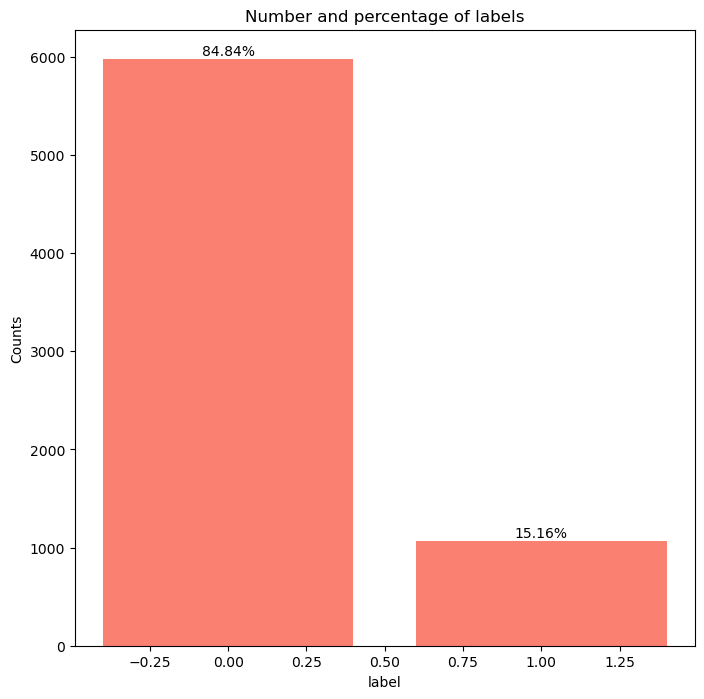

In [11]:
plot_count('label', 'labels', df)

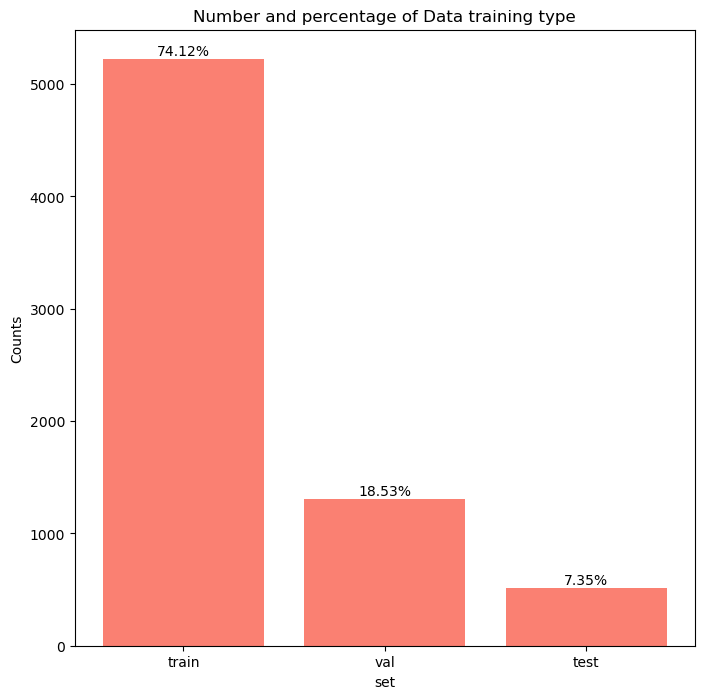

In [12]:
plot_count('set', 'Data training type', df)

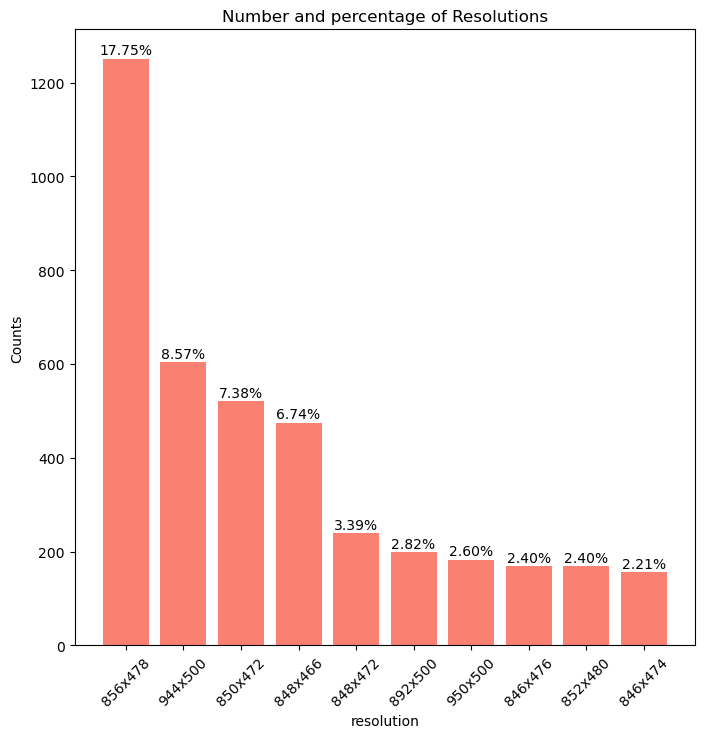

In [13]:
plot_count('resolution', 'Resolutions', df)

In [14]:
# Filter and sample a video path where label is 1 and 'id' followed by a number is in the path name
real_train_sample_video_with_id_number = list(df.loc[(df.label == 1) & (df.path.str.contains('id\d+'))].sample(1)['path'])
real_train_sample_video_with_id_number

['Celeb-real\\id38_0001.mp4']

In [15]:
# Extract the ID number from the sampled path
import re

# Get the ID number from the sampled video path
id_number = re.search(r'id(\d+)', real_train_sample_video_with_id_number[0]).group(1)
sequence_number = re.search(r'_(\d+)\.mp4', real_train_sample_video_with_id_number[0]).group(1)

# Search all videos in the df that have the same ID number
videos_with_same_id = df[df.path.str.contains(f'id{id_number}')]['path'].tolist()

first_occurrence_list_dynamic = [path for path in videos_with_same_id if re.findall(r'id\d+', path)[0] == f'id{id_number}']
second_occurrence_list_dynamic = [path for path in videos_with_same_id if len(re.findall(r'id\d+', path)) > 1 and re.findall(r'id\d+', path)[1] == f'id{id_number}']

first_occurrence_list_updated_dynamic = [
    path for path in first_occurrence_list_dynamic if f'_{sequence_number}' in path
]
second_occurrence_list_updated_dynamic = [
    path for path in second_occurrence_list_dynamic if f'_{sequence_number}' in path
]

In [16]:
def display_image_from_video_list(video_path_list):
    '''
    input: video_path_list - path for video
    process:
    0. for each video in the video path list
        1. perform a video capture from the video
        2. read the image
        3. display the image
    '''
    plt.figure()
    fig, ax = plt.subplots(4,3,figsize=(20,14))
    #we only show images extracted from first 6 videos
    for i, video_file in enumerate(video_path_list[0:12]):
      video_path = os.path.join(video_file)
      capture_img = cv.VideoCapture(video_path)
      ret, frame = capture_img.read()
      frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
      ax[i//3, i%3].imshow(frame)
      ax[i//3, i%3].set_title(f"Video: {video_file}")
      ax[i//3, i%3].axis('on')

def display_image_from_video(video_path_list):
    '''
    input: video_path_list - path for video
    process:
    0. for each video in the video path list
        1. perform a video capture from the video
        2. read the image
        3. display the image
    '''
    plt.figure()
    fig, ax = plt.subplots(1,1,figsize=(15,8))
    #we only show images extracted from first 6 videos
    video_path = video_path_list[0]
    capture_img = cv.VideoCapture(video_path)
    ret, frame = capture_img.read()
    frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    plt.imshow(frame)
    plt.title(video_path_list[0])

<Figure size 640x480 with 0 Axes>

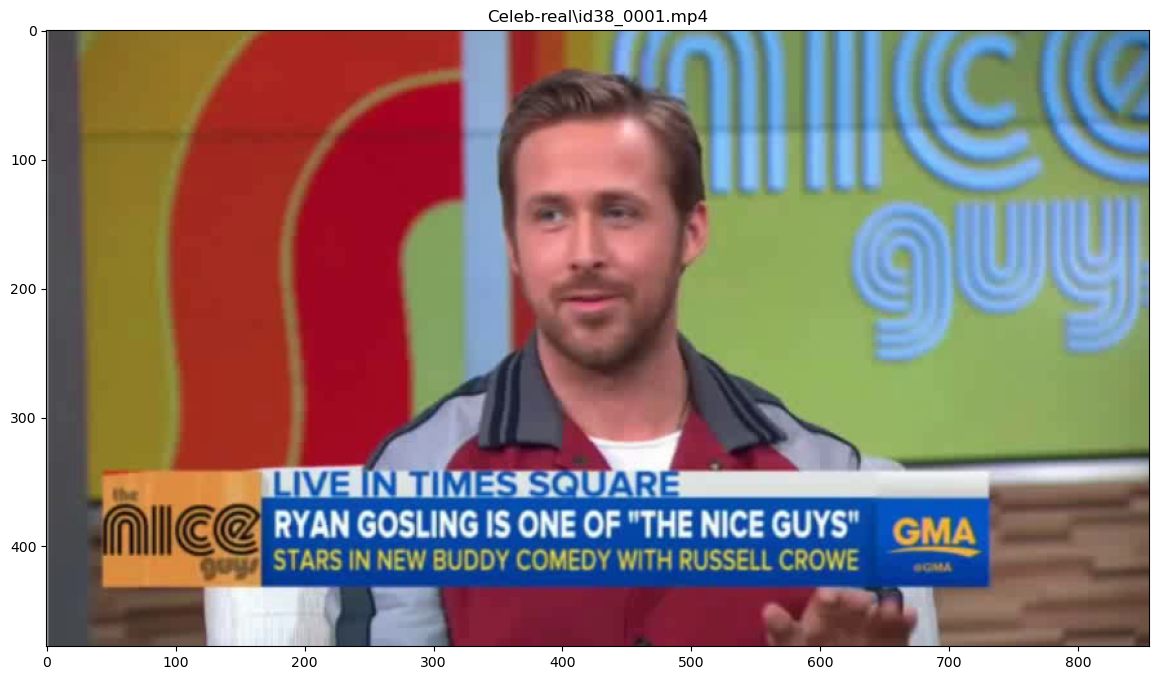

In [17]:

display_image_from_video(real_train_sample_video_with_id_number)

<Figure size 640x480 with 0 Axes>

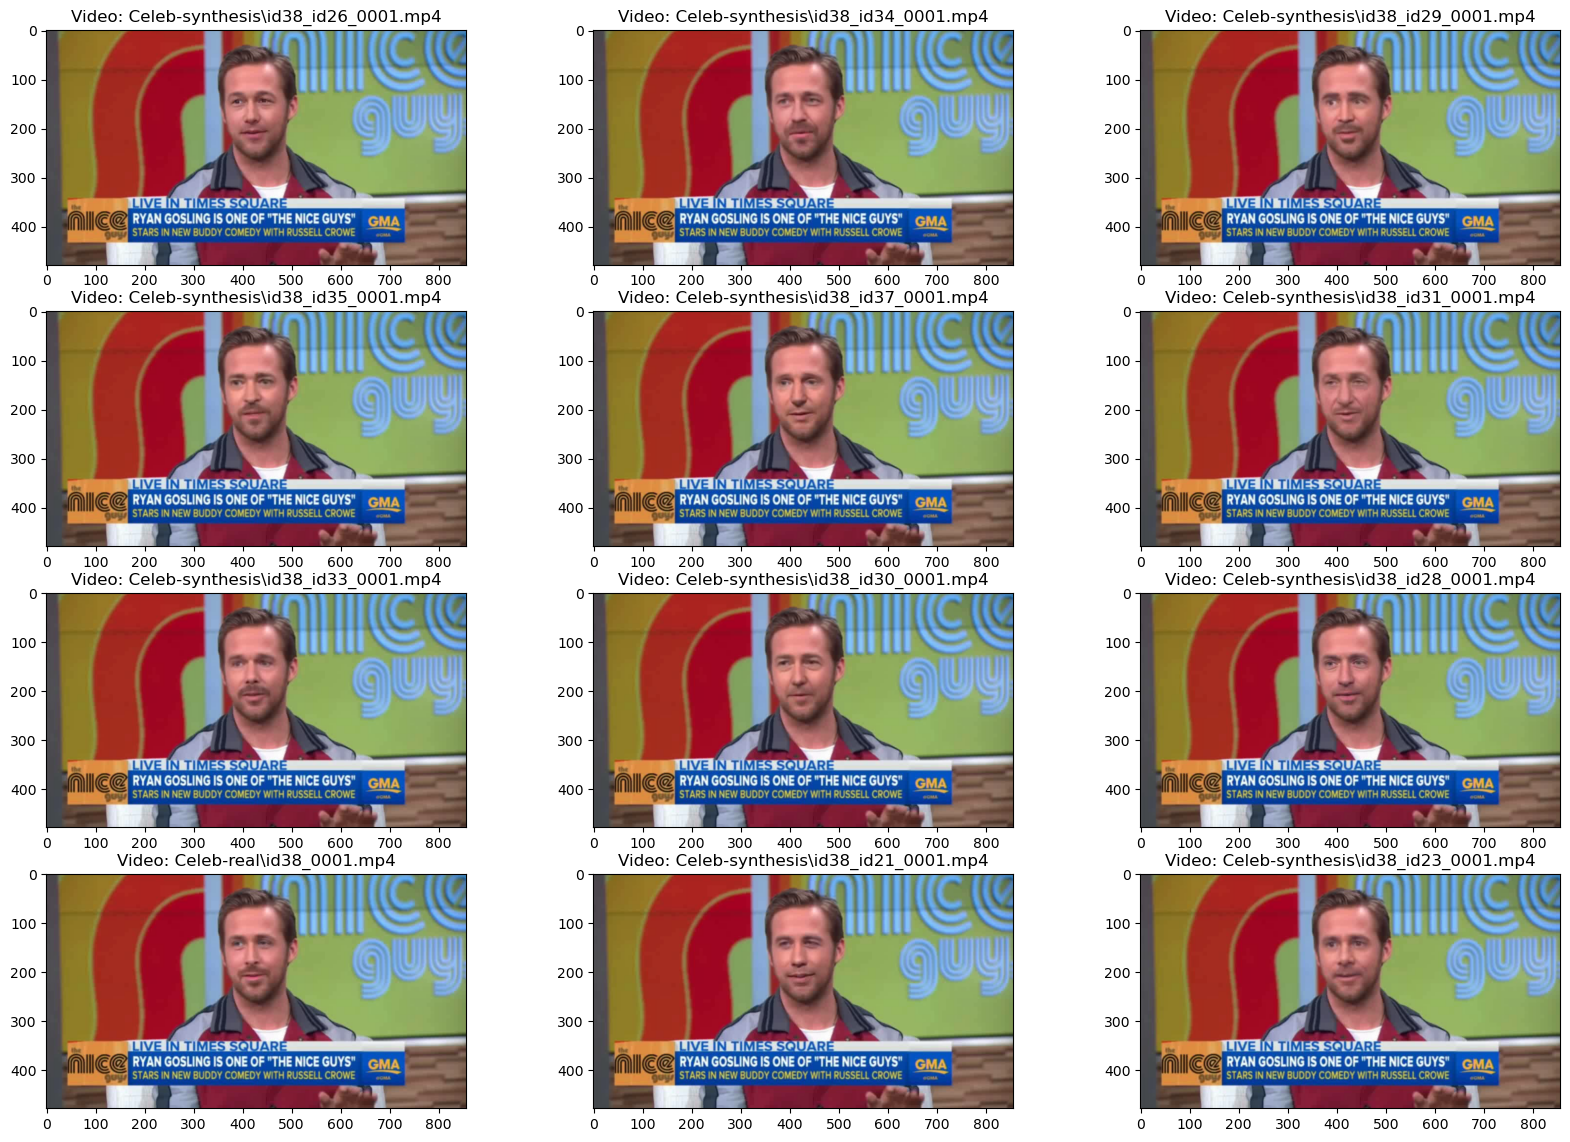

In [18]:
display_image_from_video_list(first_occurrence_list_updated_dynamic)

<Figure size 640x480 with 0 Axes>

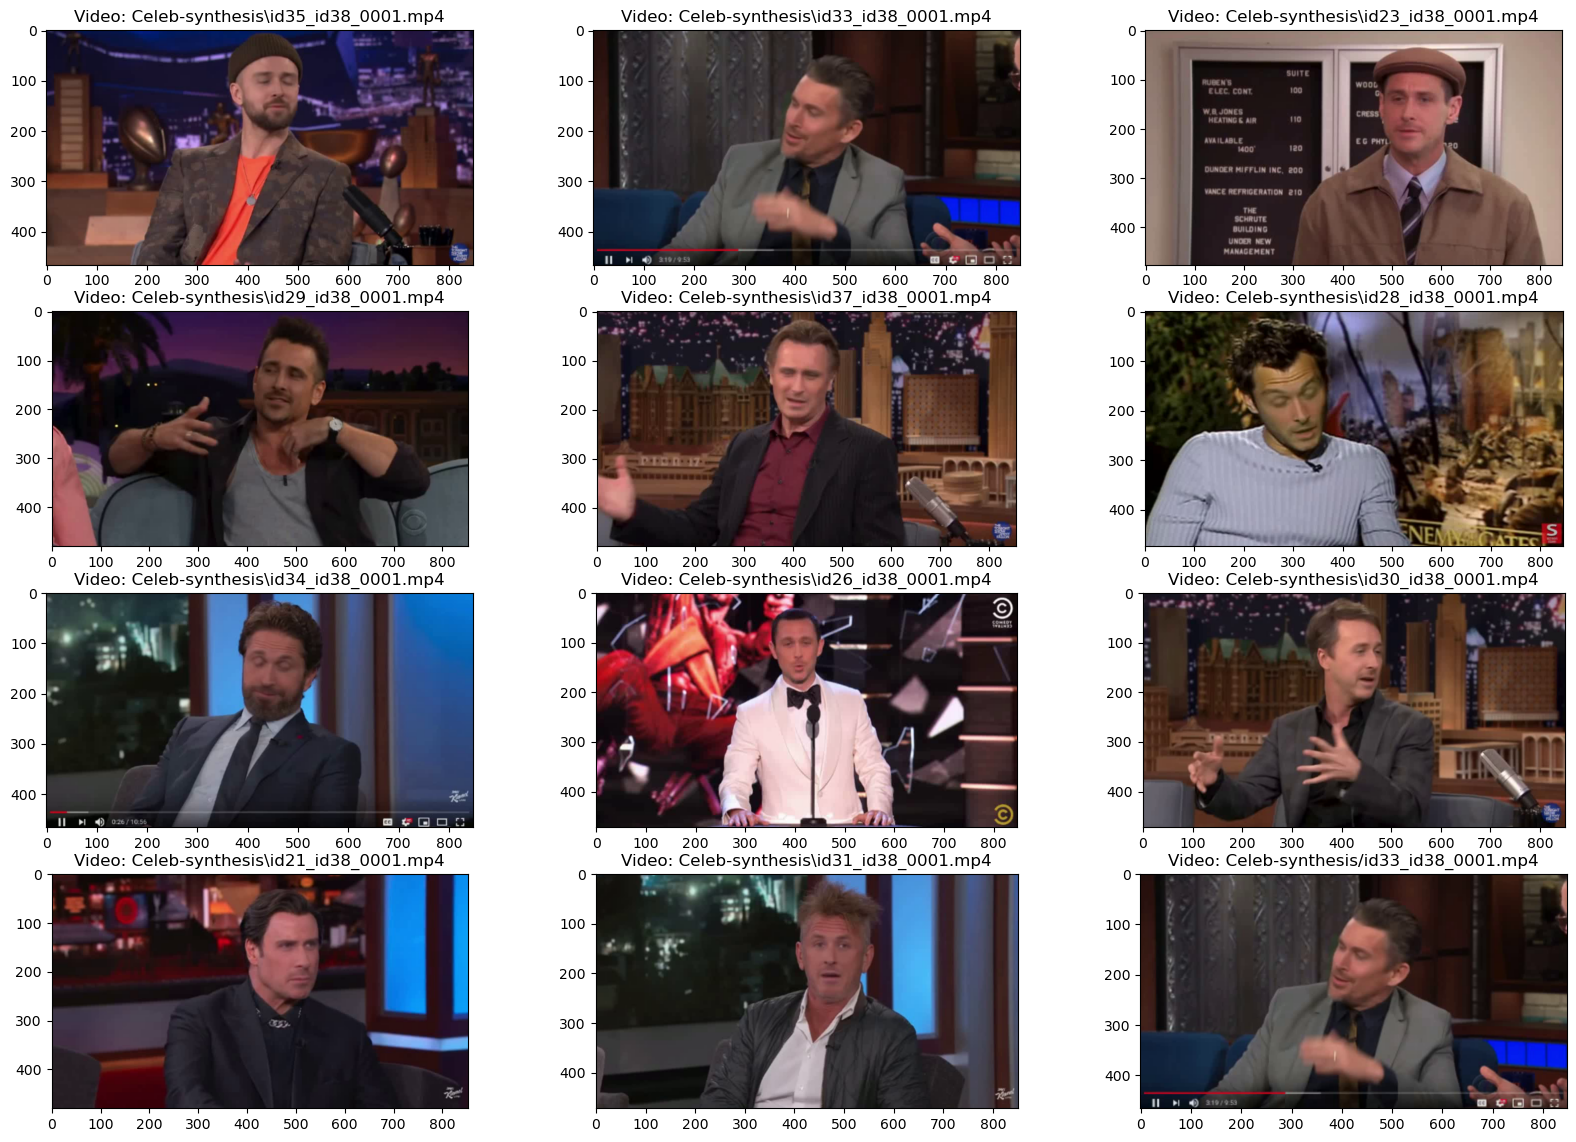

In [19]:
display_image_from_video_list(second_occurrence_list_updated_dynamic)